In [63]:
import numpy as np
from scipy.stats import multivariate_normal as MVN
import matplotlib.pyplot as plt
from scipy.optimize import root, fsolve, minimize
from numpy.linalg import norm, solve, inv
from numpy import log, zeros, eye, exp
from scipy.stats import uniform as udist
from numpy.random import rand
from matplotlib.colors import ListedColormap

from utils import prep_contour
from Manifolds.GeneralizedEllipse import GeneralizedEllipse

The constraint function is 
$$
\begin{align}
    f(x) 
    &= \log\left(\frac{1}{2}\mathcal{N}(x\mid 0, \Sigma_1) + \frac{1}{2}\mathcal{N}(x\mid 0, \Sigma_2)\right) \\
    &= \log\left(\frac{1}{4\pi}\left[(\det\Sigma_1)^{-1/2}\exp\left\{-\frac{1}{2}x^\top\Sigma_1^{-1} x\right\} + (\det\Sigma_2)^{-1/2}\exp\left\{-\frac{1}{2}x^\top\Sigma_2^{-1} x\right\}\right]\right) \\
    &= \log\left(\frac{1}{4\pi}\left[\exp\left\{-\frac{1}{2}x^\top\Sigma_1^{-1} x\right\} + \exp\left\{-\frac{1}{2}x^\top\Sigma_2^{-1} x\right\}\right]\right)
\end{align}
$$
The gradient of the constraint function with respect to $x$ is
$$
\begin{align}
    \nabla f(x)
    &= - \frac{1}{\frac{1}{4\pi}\left[\exp\left\{-\frac{1}{2}x^\top\Sigma_1^{-1} x\right\} + \exp\left\{-\frac{1}{2}x^\top\Sigma_2^{-1} x\right\}\right]}\cdot \frac{1}{4\pi}\left[\Sigma_1^{-1}x \exp\left\{-\frac{1}{2}x^\top\Sigma_1^{-1} x\right\} + \Sigma_2^{-1} x\exp\left\{-\frac{1}{2}x^\top\Sigma_2^{-1} x\right\}\right] \\
    &= \frac{\left(\exp\left\{-\frac{1}{2}x^\top\Sigma_1^{-1} x\right\}\Sigma_1^{-1} + \exp\left\{-\frac{1}{2}x^\top\Sigma_2^{-1} x\right\}\Sigma_2^{-1}\right)x}{\exp\left\{-\frac{1}{2}x^\top\Sigma_1^{-1} x\right\} + \exp\left\{-\frac{1}{2}x^\top\Sigma_2^{-1} x\right\}} \\
    &= \left[\frac{\exp\left\{-\frac{1}{2}x^\top \Sigma_1^{-1} x\right\}}{\exp\left\{-\frac{1}{2}x^\top \Sigma_1^{-1} x\right\} + \exp\left\{-\frac{1}{2}x^\top \Sigma_2^{-1} x\right\}}\Sigma_1^{-1} + \frac{\exp\left\{-\frac{1}{2}x^\top \Sigma_2^{-1} x\right\}}{\exp\left\{-\frac{1}{2}x^\top \Sigma_1^{-1} x\right\} + \exp\left\{-\frac{1}{2}x^\top \Sigma_2^{-1} x\right\}}\Sigma_2^{-1}\right] x \\
    &= \left[\frac{1}{1 + \exp\left\{-\frac{1}{2}x^\top \Sigma_2^{-1} x + \frac{1}{2}x^\top \Sigma_1^{-1}x\right\}}\Sigma_1^{-1} + \frac{1}{1 + \exp\left\{-\frac{1}{2}x^\top \Sigma_1^{-1} x + \frac{1}{2}x^\top \Sigma_2^{-1}x\right\}}\Sigma_2^{-1}\right]x \\
    &= \left[\frac{1}{1 + \exp\left\{-\frac{1}{2}x^\top (\Sigma_2^{-1} - \Sigma_1^{-1})x\right\}}\Sigma_1^{-1} + \frac{1}{1 + \exp\left\{\frac{1}{2}x^\top (\Sigma_2^{-1} - \Sigma_1^{-1})x\right\}}\Sigma_2^{-1}\right]x
\end{align}
$$

In [34]:
μ1 = np.array([0, 0])
Σ1 = np.array([[10.0, 0.0], [0.0, 0.1]])
π1 = MVN(μ1, Σ1)

μ2 = np.array([0, 0])
Σ2 = np.array([[0.1, 0.0], [0.0, 10.0]])
π2 = MVN(μ2, Σ2)

# Store values
Σ1inv = inv(Σ1)
Σ2inv = inv(Σ2)

z0 = 0.04
y = log(z0)
pdf = lambda x: 0.5*π1.pdf(x) + 0.5*π2.pdf(x)
f = lambda x: np.log(0.5*π1.pdf(x) + 0.5*π2.pdf(x))
def grad(x):
    """Computes gradient of f."""
    exponent = x.dot(Σ2inv - Σ1inv).dot(x)
    return (1/(1+np.exp(-0.5*exponent))*Σ1inv + 1/(1+np.exp(0.5*exponent))*Σ2inv).dot(x)

In [15]:
def sample_near_manifold(maxiter=100):
    u = np.random.rand()
    ellipse1 = GeneralizedEllipse(μ1, Σ1, 0.08)
    ellipse2 = GeneralizedEllipse(μ2, Σ2, 0.08)
    if u < 0.5:
        return ellipse1.sample()
    else:
        return ellipse2.sample()

def sample_on_manifold(tol=1e-8):
    start = sample_near_manifold() #np.random.uniform(low=-1, high=1, size=2)
    function = lambda xy: np.array([abs(f(xy) - y), 0.0])
    return fsolve(function, start, xtol=tol)

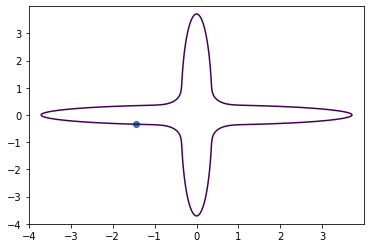

In [46]:
fig, ax = plt.subplots()
xlim = [-4, 4]
ylim = [-4, 4]

ax.contour(*prep_contour(xlim, ylim, 0.01, f), levels=[y])
ax.scatter(*sample_on_manifold())
plt.show()

In [77]:
def HugTangential(x0, δ, B, N, α, q, logpi, grad_log_pi):
    """
    Repurposed version of THUG.
    """
    # The following dictionary stores everything we need
    OUT = {
        'D' : {f"{i}": [] for i in range(N)}, # Distance
        'SD': {f"{i}": [] for i in range(N)}, # Square Distance
        'AR': [np.nan for i in range(N)],     # Acceptance Ratio
        'Δk': [np.nan for i in range(N)],     # Kinetic Energy
        'Δℓ': [np.nan for i in range(N)],     # Potential Energy
        'SAMPLES': x0,
        'ACCEPTANCES': np.zeros(N),
        'EJSD': [np.nan for i in range(N)]    # Acceptance Ratio * Squared Distance
    }
    for i in range(N):
        v0s = q.rvs()                    # Draw velocity spherically
        g = grad_log_pi(x0)              # Compute gradient at x0
        g = g / norm(g)                  # Normalize
        v0 = v0s - α * g * (g @ v0s) # Tilt velocity
        v, x = v0, x0                    # Housekeeping
        logu = np.log(rand())            # Acceptance ratio
        for _ in range(B):
            xmid = x + δ*v/2           # Move to midpoint
            g = grad_log_pi(xmid)          # Compute gradient at midpoint
            ghat = g / norm(g)          # Normalize 
            v = v - 2*(v @ ghat) * ghat # Reflect velocity using midpoint gradient
            x = xmid + δ*v/2           # Move from midpoint to end-point
            # Compute metrics
            OUT['D'][f"{i}"].append(norm(x - x0))
            OUT['SD'][f"{i}"].append(norm(x  -x0)**2)

        # Unsqueeze the velocity
        g = grad_log_pi(x)
        g = g / norm(g)
        v = v + (α / (1 - α)) * g * (g @ v)
        # In the acceptance ratio must use spherical velocities!! Hence v0s and the unsqueezed v
        logar = logpi(x) + q.logpdf(v) - logpi(x0) - q.logpdf(v0s)
        ar = exp(logar)
        OUT['AR'][i] = ar
        OUT['Δk'][i] = - norm(v)**2 + norm(v0s)**2
        OUT['Δℓ'][i] = logpi(x) - logpi(x0)
        OUT['EJSD'][i] = ar * (norm(x - x0)**2)
        if logu <= logar:
            OUT['SAMPLES'] = np.vstack((OUT['SAMPLES'], x))
            OUT['ACCEPTANCES'][i] = 1         # Accepted!
            x0 = x
        else:
            OUT['SAMPLES'] = np.vstack((OUT['SAMPLES'], x0))
            OUT['ACCEPTANCES'][i] = 0         # Rejected
    return OUT

In [78]:
# Proposal for velocity
q = MVN(zeros(2), eye(2))

# Prior function is uniform on a huge square
square_side = 10  # SQUARE SIDE
logprior  = lambda xi: udist.logpdf(xi, loc=-square_side, scale=2*square_side).sum()

In [83]:
def generate_logpi(ϵ):
    # Kernel
#     def logkernel(xi):
#         with np.errstate(divide='ignore'):
#             return log(float(norm(f(xi) - z0) < ϵ) / ϵ)
    def logkernel(xi):
        return -norm(f(xi) - y)**2/(2*(ϵ**2)) - np.log(ϵ)
    # Logpi
    logpi = lambda xi: logprior(xi) + logkernel(xi)
    return logpi

In [84]:
def generate_output(ϵs, αs, δs):
    OUTS = []
    for ϵix, ϵ in enumerate(ϵs):
        for αix, α in enumerate(αs):
            for δix, δ in enumerate(δs):
                x0 = sample_on_manifold()
                logpi = generate_logpi(ϵ)
                OUTS.append(HugTangential(x0, δ, B, N, α, q, logpi, grad))
    return OUTS

In [85]:
# Settings
ϵ = 0.001
δ = 0.1
B = 20
N = 10000

ϵs = [ϵ]
δs = [δ]
αs = [0.0, 0.5, 0.9, 0.99]

In [86]:
OUTS = generate_output(
    ϵs=ϵs,
    αs=αs,
    δs=δs
)

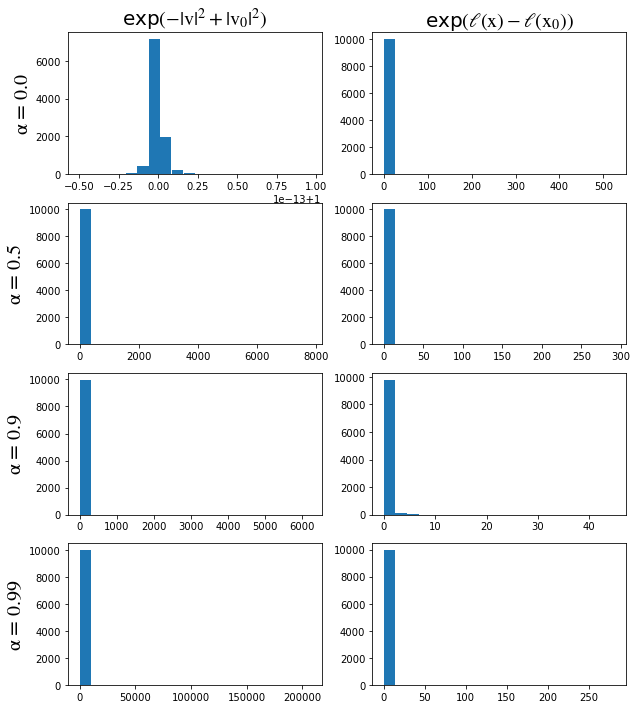

In [87]:
fig, ax = plt.subplots(nrows=len(αs), ncols=2, figsize=(10, int(3*len(αs))))
for α_ix, α in enumerate(αs):
    _ = ax[α_ix, 0].hist(np.exp(OUTS[α_ix]['Δk']), bins=20)
    _ = ax[α_ix, 1].hist(np.exp(OUTS[α_ix]['Δℓ']), bins=20)
    ax[α_ix, 0].set_ylabel(r"$\mathregular{\alpha}=$" + f"{α}", fontsize=20, fontname='STIXGeneral')
ax[0, 0].set_title(r"$\mathregular{\exp(- \|v\|^2 + \|v_0\|^2)}$", fontsize=20, fontname='STIXGeneral')
ax[0, 1].set_title(r"$\mathregular{\exp(\ell(x) - \ell(x_0))}$", fontsize=20, fontname='STIXGeneral')
plt.show()

In [88]:
def percentage_in_interval(iterable, left, right):
    """Counts the number of elements in `iterable` that are contained in the 
    interval `[left, right]`."""
    array = np.array(iterable)
    flag = (left <= array) & (array <= right)
    return (len(array[flag]) / len(array)) * 100

def prop_to_quantile_interval(p):
    """Transforms a proportion `p` into a quantile interval."""
    assert (0 <= p) and (p <= 1), "Proportion must be between 0 and 1."
    slack = (1.0 - p) / 2
    return np.array([slack, 1.0 - slack])

def generate_Δℓ_table(outs, props):
    table = zeros((len(outs), len(props)))
    for p_ix, p in enumerate(props):
        # Transform `p` into a quantile interval
        q_interval = prop_to_quantile_interval(p)
        # Find interval within which for α=0 we get p% of Δℓ in
        left, right = np.quantile(a=outs[0]['Δℓ'], q=q_interval)
        # Fill in the first row of the table
        table[0, p_ix] = percentage_in_interval(outs[0]['Δℓ'], left, right) # should be p
        # Fill in the rest of the rows for other αs
        for α_ix in range(1, len(outs)):
            table[α_ix, p_ix] = percentage_in_interval(outs[α_ix]['Δℓ'], left, right)
    return table

In [89]:
generate_Δl_table(OUTS, [0.25, 0.5, 0.75, 0.9])

array([[25.  , 50.  , 75.  , 90.  ],
       [25.02, 50.93, 77.06, 91.58],
       [16.24, 35.86, 77.19, 92.93],
       [16.27, 35.78, 79.05, 93.68]])

In [90]:
def proportion_lessthan(iterable, value):
    """Proportion of elements in iterable that are less than value."""
    array = np.array(iterable)
    flag = array <= value
    return (sum(flag) / len(array))

In [92]:
def find_value_so_prop_Δℓ_larger_new(iterable, p):
    N = len(iterable)
    
    return np.sort(np.array(iterable))[int(np.floor(N*np.round(1-p, decimals=2)))]

In [97]:
def generate_Δℓ_table_new(outs, props):
    """This table only works on intervals of the type [L, \infty)."""
    table = zeros((len(outs), len(props)))
    Ls = []
    for p_ix, p in enumerate(props):
        # Find value L so that a proportion p of samples have Δℓ larger than L
        L = find_value_so_prop_Δℓ_larger_new(outs[0]['Δℓ'], p)
        Ls.append(L)
        # Fill in the first row of the table
        table[0, p_ix] = percentage_in_interval(outs[0]['Δℓ'], L, np.inf) # should be p
        # Fill in the rest of the rows for other αs
        for α_ix in range(1, len(outs)):
            table[α_ix, p_ix] = percentage_in_interval(outs[α_ix]['Δℓ'], L, np.inf)
    return table, Ls

In [98]:
generate_Δℓ_table_new(OUTS, [0.25, 0.5, 0.75, 0.9])

(array([[25.  , 50.  , 75.  , 90.  ],
        [36.28, 66.69, 87.26, 95.82],
        [54.96, 77.55, 90.83, 96.07],
        [54.46, 77.65, 90.26, 96.48]]),
 [-0.149081341384381,
  -5.042008738031542,
  -55.065392077143024,
  -297.35076714027065])

In [99]:
def generate_latex_table(table, Ls):
    """Generate table."""
    s  = r"\begin{table}[htp]"         + "\n"
    s += r"\begin{tabular}{l|llll}"    + "\n"
    s += r"& $\Delta\ell \geq {:.2f}$ & $\Delta\ell \geq {:.2f}$ & $\Delta\ell \geq {:.2f}$ & $\Delta\ell \geq {:.2f}$ \\ \hline".format(*Ls) + "\n"
    s += r"$\alpha = 0$    & {:.0f} & {:.0f} & {:.0f} & {:.0f} \\".format(*table[0, :]) + "\n"
    s += r"$\alpha = 0.5$  & {:.2f} & {:.2f} & {:.2f} & {:.2f} \\".format(*table[1, :]) + "\n"
    s += r"$\alpha = 0.9$  & {:.2f} & {:.2f} & {:.2f} & {:.2f} \\".format(*table[2, :]) + "\n"
    s += r"$\alpha = 0.99$ & {:.2f} & {:.2f} & {:.2f} & {:.2f}".format(*table[3, :]) + "\n"
    s += r"\end{tabular}" + "\n"
    s += r"\end{table}"
    print(s)

In [100]:
generate_latex_table(*generate_Δℓ_table_new(OUTS, [0.25, 0.5, 0.75, 0.9]))

\begin{table}[htp]
\begin{tabular}{l|llll}
& $\Delta\ell \geq -0.15$ & $\Delta\ell \geq -5.04$ & $\Delta\ell \geq -55.07$ & $\Delta\ell \geq -297.35$ \\ \hline
$\alpha = 0$    & 25 & 50 & 75 & 90 \\
$\alpha = 0.5$  & 36.28 & 66.69 & 87.26 & 95.82 \\
$\alpha = 0.9$  & 54.96 & 77.55 & 90.83 & 96.07 \\
$\alpha = 0.99$ & 54.46 & 77.65 & 90.26 & 96.48
\end{tabular}
\end{table}
